### 线性回归的从零开始实现
我们将从零开始实现整个方法，包括数据流水线、模型、损失函数和小批量随机梯度下降优化器

In [58]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

根据带有噪声的线性模型构造一个人造数据集。我们使用线性模型参数$w=[2,−3.4]^⊤$,b=4.2和噪声项$ϵ$来生成数据集及其标签：
$$y=Xw+b+ϵ$$

In [59]:
def synthetic_data(w, b, num_examples):
    """生成 y = Xw + b + 噪声。"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01,
                      y.shape)  # 给生成的标签y添加一个均值为0，标准差为0.01的正态分布噪声，模拟真实数据中的噪声
    return X, y.reshape(
        (-1, 1)
    )  # 返回生成的特征X和标签y。其中标签y通过y.reshape((-1, 1))将形状从(num_examples,)改变为(num_examples, 1)，以便与特征X的形状保持一致。


true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

`features`中的每一行都包含一个二维数据样本，`labels`中的每一行都包含一维标签值（一个标量）

In [60]:
print('features:', features[0], '\nlabel:', labels[0])

features: tensor([1.7622, 0.4151]) 
label: tensor([6.3072])


下面这段代码使用d2l库中的函数绘制散点图，用于可视化数据集中的样本分布情况。

解释如下：

1. `d2l.set_figsize()`: 这是d2l库中的一个函数，用于设置Matplotlib图形的大小。该函数没有给定具体的大小参数，因此可能使用默认的图形大小。

2. `d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1)`: 这行代码绘制散点图。

   - `features[:, (1)]`: `features`是之前生成的数据集中的特征矩阵，其中包含1000个样本和两个特征。`features[:, (1)]`表示选取所有样本的第二个特征（Python索引从0开始，所以索引为1表示第二个特征）。
   
   - `.detach().numpy()`: 在PyTorch中，`features`和`labels`都是张量（tensor）对象。`.detach()`用于**从计算图中分离出张量，并返回一个新的张量，不再与原来的计算图产生关联。`.numpy()`用于将PyTorch张量转换为NumPy数组，以便在Matplotlib中使用**。
   
   - `labels`: `labels`是之前生成的数据集中的标签，表示1000个样本的真实标签。
   
   - `1`: **这是指定绘制的散点的大小参数，值为1表示散点的大小为1个像素**。
   
   整个代码行的作用是绘制特征矩阵中第二个特征与对应标签之间的散点图。每个样本在散点图中以一个像素大小的点表示，**点的位置由第二个特征的值和对应标签的值确定**。这样可以直观地展示特征与标签之间的关系，帮助我们理解数据集的分布情况。

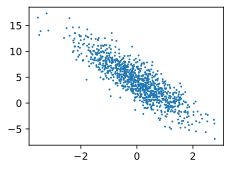

In [61]:
d2l.set_figsize()
d2l.plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1)


定义一个`data_iter`函数，该函数接收批量大小、特征矩阵和标签向量作为输入，生成大小为`batch_size`的小批量，每个小批量包含一组特征和标签。

In [62]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))  # 生成一个样本索引列表
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        # 每次返回batch_size个随机样本的特征和标签,当最后一次不足一个batch_size时，返回剩余的样本
        batch_indices = torch.tensor(indices[i:min(i +
                                                   batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]
        # 使用Python的yield语句生成当前批次的特征和标签。yield语句使函数成为一个生成器（generator），
        # 当调用该函数时，并不执行函数体的全部代码，而是生成一个迭代器，每次迭代生成一个批次的数据。


batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    # 使用for循环迭代生成器data_iter，在每次迭代中获取一个批次的特征X和标签y。
    print(X, '\n', y)
    # 表示在获取第一个批次后终止迭代，只是为了演示目的。实际应用中，通常会对整个数据集进行多个迭代。
    break

tensor([[ 0.0454,  0.1812],
        [-0.0823,  1.0186],
        [-1.0502, -0.3241],
        [-0.8548, -1.5566],
        [ 1.3991, -0.4830],
        [-0.5498, -1.5263],
        [ 0.9565, -1.9979],
        [ 0.3885, -0.2365],
        [-1.3991,  0.2638],
        [-0.8805, -1.4471]]) 
 tensor([[ 3.6754],
        [ 0.5681],
        [ 3.1978],
        [ 7.7809],
        [ 8.6310],
        [ 8.2641],
        [12.9194],
        [ 5.8004],
        [ 0.5187],
        [ 7.3482]])


In [63]:
# 定义初始化模型参数
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

In [64]:
# 定义模型
def linreg(X,w,b):
    """线性回归模型"""
    return torch.matmul(X,w)+b

In [65]:
# 定义损失函数
def squared_loss(y_hat, y):
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2    # 这里返回的是向量，这里没有求均值

In [66]:
# 定义优化算法
def sgd(params, lr, batch_size):    # `params` 是一个包含需要优化的参数张量的列表
    """小批量随机梯度下降。"""
    with torch.no_grad():
        # `with torch.no_grad():`: 这是一个上下文管理器（context manager）
        # 在该上下文管理器内部的代码块中，PyTorch会关闭对梯度的自动跟踪，从而避免对参数更新造成影响的梯度追踪
        # 我们通常在参数更新时使用`torch.no_grad()`来避免不必要的计算和内存消耗。
        for param in params:
            # 小批量随机梯度下降算法的更新公式为：`参数 = 参数 - 学习率 * 参数的梯度 / 批次大小`,因为上面没有求均值，所以这里求均值
            param -= lr * param.grad / batch_size
            param.grad.zero_()

In [67]:
lr = 0.03
num_epochs = 3  # 定义训练周期的数量，也称为迭代次数。在每个训练周期内，将遍历整个数据集进行参数更新。也就是将整个数据集扫三遍
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)   # `X` 和 `y` 的小批量损失
        # 因为 `l` 形状是 (`batch_size`, 1)，而不是一个标量。`l` 中的所有元素被加到一起，
        # 并以此计算关于 [`w`, `b`] 的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    with torch.no_grad():
        # 计算整个训练集上的损失，用于在每个训练周期结束时输出模型的训练进度
        train_l = loss(net(features, w, b), labels)

        # `:f`: 这是格式规范符，用于指定输出浮点数的格式。在这里，`:f` 表示输出为带有小数点的浮点数。
        # 通过使用 `:f` 格式规范符，可以保证输出的损失值为浮点数，并且带有小数点，避免输出整数形式的损失值。
        # 在深度学习中，损失值通常是浮点数，因为它是通过对预测值与真实标签之间的差距进行均方损失计算得到的。
        # 因此，使用 `:f` 格式规范符更符合损失值的实际类型，更易于理解和解释。
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.035540
epoch 2, loss 0.000127
epoch 3, loss 0.000053


In [68]:
# 比较真实参数和通过训练学到的参数来评估训练的成功程度
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([9.0361e-05, 5.0521e-04], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0008], grad_fn=<RsubBackward1>)
